In [2]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import grangercausalitytests
from sklearn_extra.cluster import KMedoids
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import dendrogram, linkage

import seaborn as sns
import matplotlib.pyplot as plt

import os
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Modified function to compute Granger Causality matrix focusing on target and X_columns
def compute_causality_graph(data, target_var, lag_p=5):
    feature_vars = [col for col in data.columns if col.startswith('X')]
    gMat = pd.DataFrame(np.zeros((len(feature_vars), 1)), columns=[target_var], index=feature_vars)
    for feature in feature_vars:
        print(feature)
        test_result = grangercausalitytests(data[[feature, target_var]], lag_p, verbose=False)
        p_value = test_result[lag_p][0]['ssr_ftest'][1]
        gMat.loc[feature, target_var] = 1 - p_value
    return gMat

In [4]:
def gfsm(F, gmat, target_var, threshold, clus, nbre_vars):
    causality = gmat[target_var]
    relevant_vars = causality[causality >= threshold].index.tolist()

    if clus:
        if len(relevant_vars) > 1:
            reduced_gmat = gmat.loc[relevant_vars, [target_var]].T
            distances = pdist(reduced_gmat, metric='euclidean')
            dist_matrix = squareform(distances)

            # Ensure the number of clusters does not exceed the number of samples
            k = min(nbre_vars, len(relevant_vars), dist_matrix.shape[0])
            if k > 1:
                kmedoids = KMedoids(n_clusters=k, random_state=0).fit(dist_matrix)
                labels = kmedoids.labels_
                best_vars = []
                for cluster_idx in range(k):
                    cluster_members = [relevant_vars[idx] for idx, label in enumerate(labels) if label == cluster_idx]
                    best_var = max(cluster_members, key=lambda var: causality[var])
                    best_vars.append(best_var)
                GSM = F[best_vars]
            else:
                GSM = F[relevant_vars[:1]]
        else:
            GSM = F[relevant_vars[:1]]
    else:
        GSM = F[relevant_vars[:min(nbre_vars, len(relevant_vars))]]

    return GSM


In [5]:
# Function for displaying heatmap
def display_heatmap(gmat, file_path):
    plt.figure(figsize=(12, 10))
    sns.heatmap(gmat, cmap='viridis')
    plt.title('Granger Causality Matrix')
    plt.savefig(file_path, format='png')
    plt.show()

Processing Y1 data:
X1
X10
X100
X101
X102
X103
X104
X105
X106
X107
X108
X109
X11
X110
X111
X112
X113
X114
X116


,Y1
X1,0.999535
X10,0.999986
X100,0.972929
X101,0.987726
X102,0.524035
X103,0.941248
X104,0.950887
X105,0.909137
X106,0.932358
X107,0.944595


'Saving Granger Causality Matrix heatmap for Y1...'

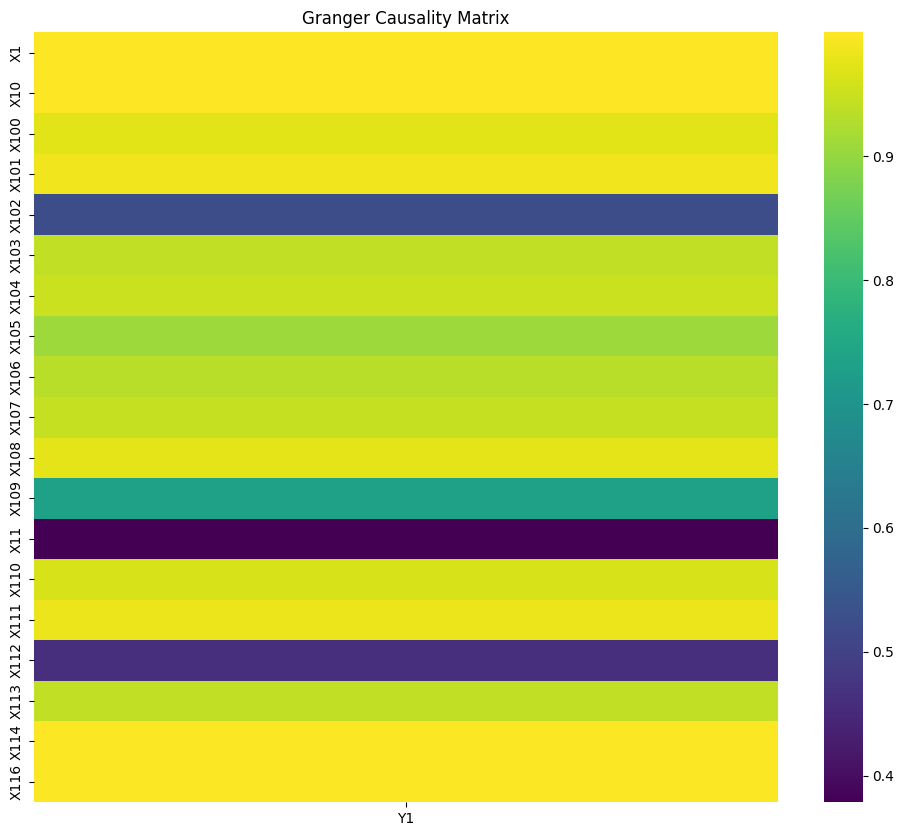

,X1
datetime,
2022-01-03 09:45:01,-1.985130
2022-01-03 09:45:02,-0.933646
2022-01-03 09:45:03,-0.579249
2022-01-03 09:45:04,-0.658292
2022-01-03 09:45:05,-1.331419
...,...
2022-01-03 09:59:56,-0.027713
2022-01-03 09:59:57,0.380730
2022-01-03 09:59:58,0.144590



Processing Y2 data:


In [8]:
# Main function
def main(file_name, target_var, threshold, output_dir):
    data = pd.read_pickle(file_name)
    data.replace([np.inf, -np.inf], np.nan, inplace=True)
    data.fillna(method='ffill', inplace=True)
    feature_vars = [col for col in data.columns if col.startswith('X')]
    data = data[[target_var] + feature_vars]

    gmat = compute_causality_graph(data, target_var)
    display(gmat)

    # Save heatmap
    heatmap_path = os.path.join(output_dir, f'granger_causality_heatmap_{target_var}.png')
    display(f"Saving Granger Causality Matrix heatmap for {target_var}...")
    display_heatmap(gmat, heatmap_path)

    # Calculate and display gfsm_result
    gfsm_result = gfsm(data, gmat, target_var, threshold, clus=True, nbre_vars=5)
    display(gfsm_result)

    # Save gfsm_result to a pickle file
    gfsm_result.to_pickle(f'{target_var}_Selected.pkl')

# Running the main function
if __name__ == "__main__":
    output_dir = 'Plot n result save'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    threshold = 0.99
    print("Processing Y1 data:")
    main('Datasave/Q1_filtered2_0.6.pkl', 'Y1', threshold, output_dir)

    print("\nProcessing Y2 data:")
    main('Datasave/Q2_filtered2_0.6.pkl', 'Y2', threshold, output_dir)


In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import grangercausalitytests
from sklearn_extra.cluster import KMedoids
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import dendrogram, linkage

import seaborn as sns
import matplotlib.pyplot as plt

import os
import warnings
warnings.filterwarnings('ignore')

# Assuming the preprocess_data function cleans the data and handles missing values
def preprocess_data(file_path):
    data = pd.read_pickle(file_path)
    # Replace infinite values with NaN and fill missing values
    data.replace([np.inf, -np.inf], np.nan, inplace=True)
    data.fillna(method='ffill', inplace=True)
    # Filter for target variable and feature variables
    target_var = 'Y1'
    feature_vars = [col for col in data.columns if col.startswith('X')]

    # Create a new DataFrame with the selected columns
    data = data[[target_var] + feature_vars]
    data = data.iloc[:9000,:10]
    return data

In [2]:
# Function to compute Granger Causality matrix
def compute_causality_graph(data, lag_p=5):
    gMat = pd.DataFrame(np.zeros((len(data.columns), len(data.columns))), columns=data.columns, index=data.columns)
    for i in data.columns:
        for j in data.columns:
            if i != j:
                print(i,j)
                test_result = grangercausalitytests(data[[j, i]], lag_p, verbose=False)
                p_value = test_result[lag_p][0]['ssr_ftest'][1]
                gMat.loc[i, j] = 1 - p_value
            else:
                gMat.loc[i, j] = 0
    return gMat

In [3]:
# Function to filter and cluster variables based on Granger Causality matrix
def gfsm(F, gmat, target_index, threshold, clus, nbre_vars):
    causality = gmat.iloc[:, target_index]
    relevant_vars = causality[causality >= threshold].index.tolist()
    
    if nbre_vars == 1:
        max_caus_var = relevant_vars[0]
        for var in relevant_vars[1:]:
            if causality[var] > causality[max_caus_var]:
                max_caus_var = var
        GSM = F[[max_caus_var]]
        return GSM
    
    if clus:
        distances = pdist(gmat.loc[relevant_vars, relevant_vars], metric='euclidean')
        dist_matrix = squareform(distances)
        k = nbre_vars
        kmedoids = KMedoids(n_clusters=k, random_state=0).fit(dist_matrix)
        labels = kmedoids.labels_
        best_vars = []
        for cluster_idx in range(k):
            cluster_members = [relevant_vars[idx] for idx, label in enumerate(labels) if label == cluster_idx]
            best_var = max(cluster_members, key=lambda var: causality[var])
            best_vars.append(best_var)
        GSM = F[best_vars]
    else:
        GSM = F[relevant_vars[:nbre_vars]]
    
    return GSM

In [4]:
def display_heatmap(gmat, file_path):
    plt.figure(figsize=(12, 10))
    sns.heatmap(gmat, cmap='viridis')
    plt.title('Granger Causality Matrix')
    plt.savefig(file_path, format='png')
    plt.show()

In [5]:
def create_cluster_map(gMat, kmedoids, file_path):
    # Obtain the labels and medoid indices from the fitted KMedoids object
    clusters = kmedoids.labels_
    medoid_indices = kmedoids.medoid_indices_
    
    # Create a linkage matrix for the rows using the medoid indices
    row_linkage = linkage(gMat.values[medoid_indices], method='average')
    
    # Create a linkage matrix for the columns using the medoid indices
    col_linkage = linkage(gMat.values[:, medoid_indices].T, method='average')
    
    # Create a cluster map using seaborn
    sns.clustermap(gMat, row_linkage=row_linkage, col_linkage=col_linkage, figsize=(6, 6), cmap='viridis')
    plt.title('Cluster Map of Granger Causality Scores')
    plt.savefig(file_path, format='png')
    plt.show()

Processing Y1 data:
Y1 X1
Y1 X10
Y1 X100
Y1 X101
Y1 X102
Y1 X103
Y1 X104
Y1 X105
Y1 X106
Y1 X107
Y1 X108
Y1 X109
Y1 X11
Y1 X110
Y1 X111
Y1 X112
Y1 X113
Y1 X114
Y1 X116
X1 Y1
X1 X10
X1 X100
X1 X101
X1 X102
X1 X103
X1 X104
X1 X105
X1 X106
X1 X107
X1 X108
X1 X109
X1 X11
X1 X110
X1 X111
X1 X112
X1 X113
X1 X114
X1 X116
X10 Y1
X10 X1
X10 X100
X10 X101
X10 X102
X10 X103
X10 X104
X10 X105
X10 X106
X10 X107
X10 X108
X10 X109
X10 X11
X10 X110
X10 X111
X10 X112
X10 X113
X10 X114
X10 X116
X100 Y1
X100 X1
X100 X10
X100 X101
X100 X102
X100 X103
X100 X104
X100 X105
X100 X106
X100 X107
X100 X108
X100 X109
X100 X11
X100 X110
X100 X111
X100 X112
X100 X113
X100 X114
X100 X116
X101 Y1
X101 X1
X101 X10
X101 X100
X101 X102
X101 X103
X101 X104
X101 X105
X101 X106
X101 X107
X101 X108
X101 X109
X101 X11
X101 X110
X101 X111
X101 X112
X101 X113
X101 X114
X101 X116
X102 Y1
X102 X1
X102 X10
X102 X100
X102 X101
X102 X103
X102 X104
X102 X105
X102 X106
X102 X107
X102 X108
X102 X109
X102 X11
X102 X110
X102 X111
X102 X

,Y1,X1,X10,X100,X101,X102,X103,X104,X105,X106,X107,X108,X109,X11,X110,X111,X112,X113,X114,X116
Y1,0.000000,0.999995,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000
X1,0.947842,0.000000,0.873543,0.612186,0.999752,0.768401,0.925682,0.714011,0.700611,0.999999,0.857542,0.946893,0.989778,0.847884,0.336192,0.999335,0.621264,0.887253,0.99997,0.850985
X10,0.029249,0.999999,0.000000,0.998701,0.951670,1.000000,0.890040,1.000000,0.996893,0.943698,1.000000,0.998895,0.999998,0.976618,0.999995,0.965555,0.999999,0.999585,1.00000,1.000000
X100,0.366711,1.000000,1.000000,0.000000,1.000000,0.999654,0.903483,0.913628,1.000000,1.000000,0.999988,0.996984,0.999873,1.000000,1.000000,1.000000,0.999986,0.999993,1.00000,1.000000
X101,0.989163,1.000000,1.000000,1.000000,0.000000,1.000000,0.024900,0.985269,1.000000,1.000000,1.000000,0.818005,0.999973,1.000000,1.000000,1.000000,1.000000,0.999995,1.00000,1.000000
X102,0.999717,1.000000,1.000000,1.000000,0.999998,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000
X103,0.979768,1.000000,1.000000,1.000000,0.999912,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000
X104,0.998061,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000
X105,0.536536,1.000000,1.000000,0.998323,1.000000,0.999717,0.916245,0.561578,0.000000,1.000000,0.999931,0.949822,0.998123,1.000000,1.000000,1.000000,0.999954,0.999939,1.00000,1.000000
X106,0.995116,1.000000,1.000000,1.000000,0.998559,1.000000,0.266686,0.830740,1.000000,0.000000,1.000000,0.164973,0.999920,1.000000,1.000000,1.000000,1.000000,0.999995,1.00000,1.000000


Saving Granger Causality Matrix heatmap...


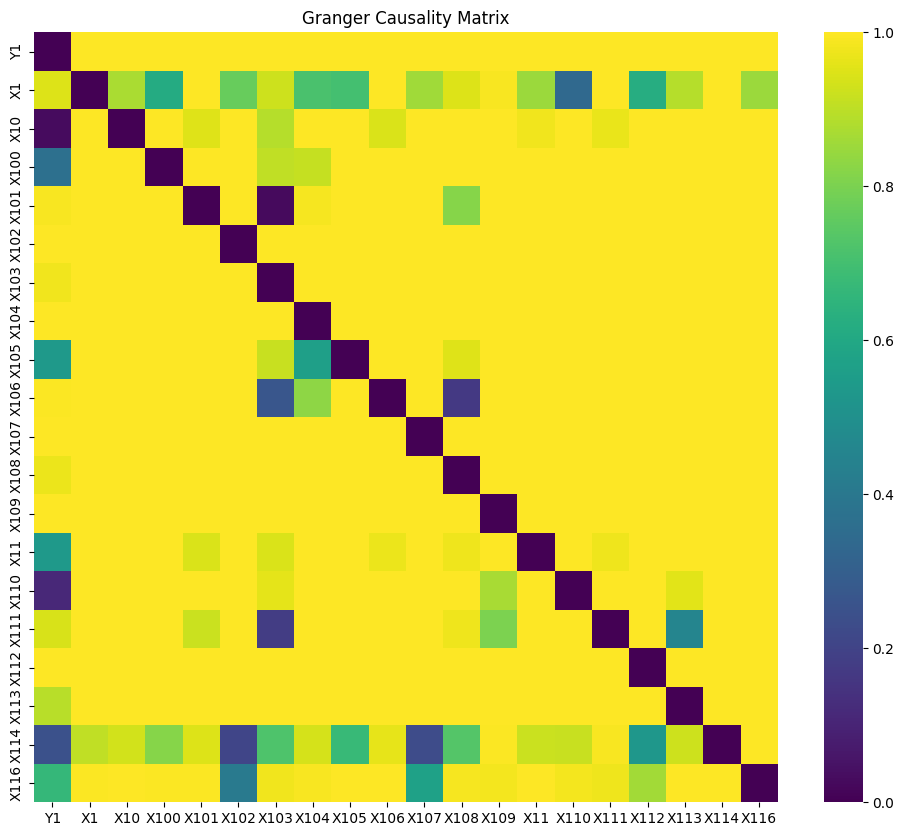

,X109,X106,X104,X112,X107
datetime,,,,,
2022-12-01 09:45:01,0.501056,1.863185,-0.126623,0.757313,0.301126
2022-12-01 09:45:02,-0.244531,0.390355,-0.906475,-0.215339,-0.701922
2022-12-01 09:45:03,-0.117508,0.055688,-0.795086,-0.078066,-0.574928
2022-12-01 09:45:04,0.479175,1.322167,-0.126857,0.449370,0.019285
2022-12-01 09:45:05,0.377025,1.058229,-0.172544,0.190796,-0.210432


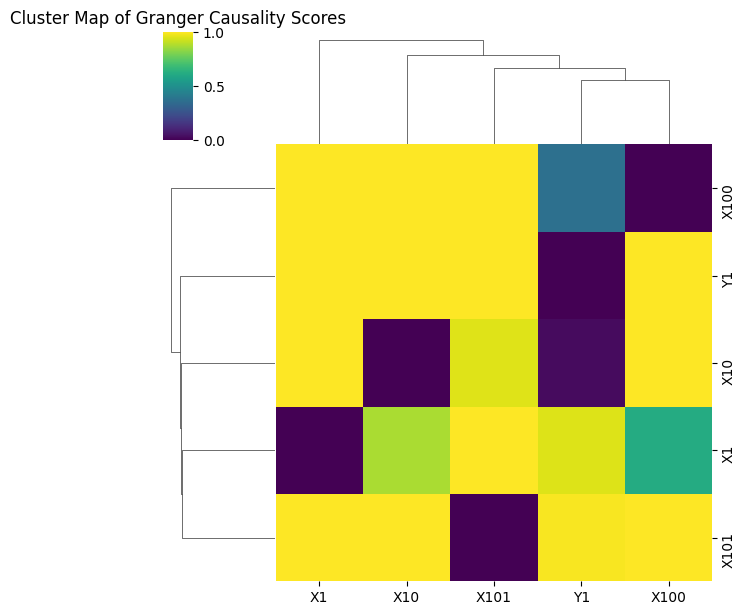


Processing Y2 data:
Y2 X1
Y2 X10
Y2 X100
Y2 X101
Y2 X102
Y2 X103
Y2 X104
Y2 X105
Y2 X106
Y2 X107
Y2 X108
Y2 X109
Y2 X11
Y2 X110
Y2 X111
Y2 X112
Y2 X113
Y2 X118
Y2 X119
X1 Y2
X1 X10
X1 X100
X1 X101
X1 X102
X1 X103
X1 X104
X1 X105
X1 X106
X1 X107
X1 X108
X1 X109
X1 X11
X1 X110
X1 X111
X1 X112
X1 X113
X1 X118
X1 X119
X10 Y2
X10 X1
X10 X100
X10 X101
X10 X102
X10 X103
X10 X104
X10 X105
X10 X106
X10 X107
X10 X108
X10 X109
X10 X11
X10 X110
X10 X111
X10 X112
X10 X113
X10 X118
X10 X119
X100 Y2
X100 X1
X100 X10
X100 X101
X100 X102
X100 X103
X100 X104
X100 X105
X100 X106
X100 X107
X100 X108
X100 X109
X100 X11
X100 X110
X100 X111
X100 X112
X100 X113
X100 X118
X100 X119
X101 Y2
X101 X1
X101 X10
X101 X100
X101 X102
X101 X103
X101 X104
X101 X105
X101 X106
X101 X107
X101 X108
X101 X109
X101 X11
X101 X110
X101 X111
X101 X112
X101 X113
X101 X118
X101 X119
X102 Y2
X102 X1
X102 X10
X102 X100
X102 X101
X102 X103
X102 X104
X102 X105
X102 X106
X102 X107
X102 X108
X102 X109
X102 X11
X102 X110
X102 X111
X102 

,Y2,X1,X10,X100,X101,X102,X103,X104,X105,X106,X107,X108,X109,X11,X110,X111,X112,X113,X118,X119
Y2,0.000000,0.999914,1.000000,1.000000,1.000000,1.000000,0.999999,1.000000,1.000000,1.000000,1.000000,0.999998,1.000000,0.999985,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
X1,0.829855,0.000000,0.947931,1.000000,0.999709,0.999999,0.991509,0.826451,1.000000,0.999999,0.999958,0.999996,0.835993,0.999510,0.999972,0.999874,0.601807,0.938956,1.000000,1.000000
X10,0.000594,0.999999,0.000000,0.933186,0.948506,1.000000,0.881844,1.000000,0.954943,0.943585,1.000000,0.920000,1.000000,0.999658,0.985562,0.968782,1.000000,0.999484,0.999972,0.941327
X100,0.777624,1.000000,1.000000,0.000000,1.000000,0.999991,0.967445,0.998984,1.000000,1.000000,0.999999,0.999693,1.000000,1.000000,1.000000,1.000000,1.000000,0.999985,1.000000,1.000000
X101,0.621206,1.000000,1.000000,1.000000,0.000000,1.000000,0.360213,0.998754,1.000000,1.000000,1.000000,0.999999,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
X102,0.824489,1.000000,1.000000,0.985831,0.998838,0.000000,1.000000,0.999999,0.999999,0.999995,1.000000,1.000000,1.000000,1.000000,0.999993,0.999667,1.000000,1.000000,1.000000,1.000000
X103,0.506234,1.000000,1.000000,0.999999,0.999005,1.000000,0.000000,1.000000,1.000000,0.999999,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
X104,0.883871,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
X105,0.838735,1.000000,1.000000,0.998323,1.000000,0.999990,0.954686,0.897691,0.000000,1.000000,0.999997,0.979485,0.999978,1.000000,1.000000,1.000000,0.999999,0.999796,1.000000,1.000000
X106,0.794618,1.000000,1.000000,1.000000,0.992395,1.000000,0.609656,0.886246,1.000000,0.000000,1.000000,0.999360,0.999999,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Saving Granger Causality Matrix heatmap...


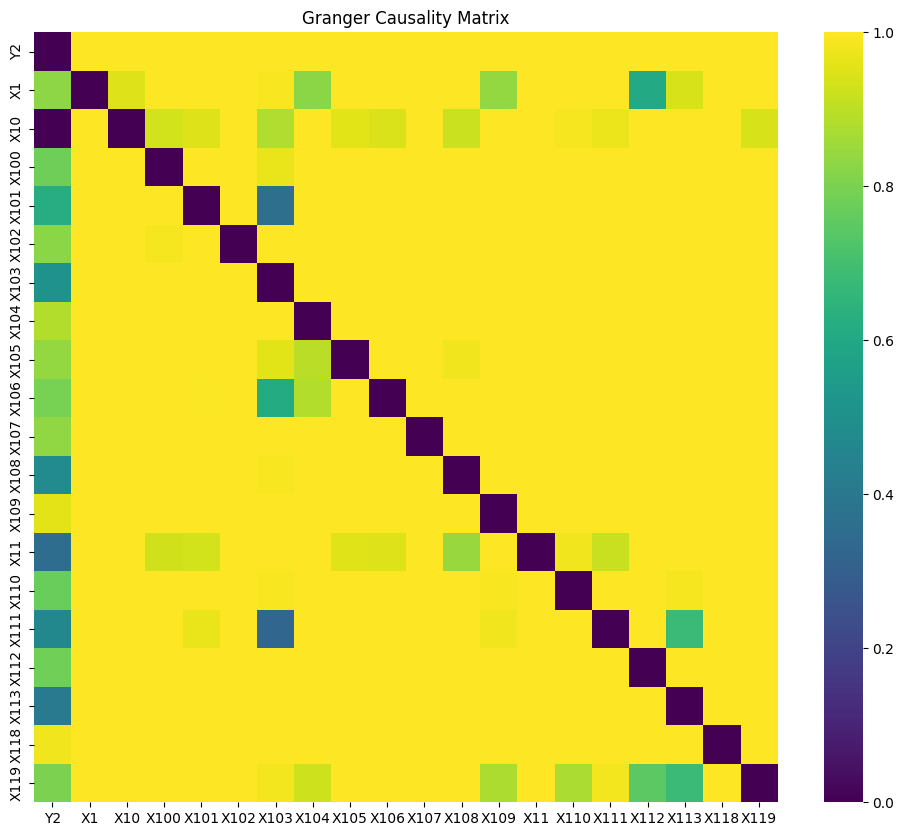

ValueError: The number of medoids (5) must be less than the number of samples 1.

In [7]:
# Main function to handle data processing and plotting
def main(file_name, target_var, threshold, output_dir):
    data = pd.read_pickle(file_name)
    
    # Replace infinite values with NaN and fill missing values
    data.replace([np.inf, -np.inf], np.nan, inplace=True)
    data.fillna(method='ffill', inplace=True)
    
    # Filter for target variable and feature variables
    feature_vars = [col for col in data.columns if col.startswith('X')]
    data = data[[target_var] + feature_vars]
    # Filter the data for the latest 3 months
    data = data.last('3M')
    data = data.iloc[:9000,:20]
    
    # Compute Granger causality graph
    gmat = compute_causality_graph(data)
    display(gmat)

    # Save Granger Causality Matrix
    gmat_csv_path = os.path.join(output_dir, 'granger_causality_matrix.csv')
    gmat.to_csv(gmat_csv_path)

    # Save heatmap of Granger Causality Matrix
    heatmap_path = os.path.join(output_dir, 'granger_causality_heatmap.png')
    print("Saving Granger Causality Matrix heatmap...")
    display_heatmap(gmat, heatmap_path)

    # Assuming target_index is known
    target_index = data.columns.get_loc(target_var)
    gfsm_result = gfsm(data, gmat, target_index, threshold, clus=True, nbre_vars=5)
    
    # Display the first 5 rows of the result
    display(gfsm_result.head())

  
        
    # Perform KMedoids clustering
    distances = pdist(gmat, metric='euclidean')
    dist_matrix = squareform(distances)
    kmedoids = KMedoids(n_clusters=5, random_state=0).fit(dist_matrix)  # Change n_clusters to the desired number
    
    # Save cluster map
    cluster_map_path = os.path.join(output_dir, 'cluster_map.png')
    create_cluster_map(gmat, kmedoids, cluster_map_path)

if __name__ == "__main__":
    # Define output directory for saving plots
    output_dir = 'output_plots'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Set the threshold for cumulative importance
    threshold = 0.99
    
    # Process Y1 data
    print("Processing Y1 data:")
    main('Datasave/Q1_filtered2_0.6.pkl', 'Y1', threshold, output_dir)

    # Uncomment to process Y2 data similarly
    print("\nProcessing Y2 data:")
    main('Datasave/Q2_filtered2_0.6.pkl', 'Y2', threshold, output_dir)

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import grangercausalitytests
from sklearn_extra.cluster import KMedoids
from scipy.spatial.distance import pdist, squareform
import warnings

# Suppress warnings from LightGBM
warnings.filterwarnings('ignore')

# # Load data from pickle file
# data = pd.read_pickle('Datasave/Q1_filtered2_0.6.pkl')

# # Replace infinite values with NaN and fill missing values
# data.replace([np.inf, -np.inf], np.nan, inplace=True)
# data.fillna(method='ffill', inplace=True)
# # Select target variable 'Y1' and feature variables starting with 'X'
# target_var = 'Y1'
# feature_vars = [col for col in data.columns if col.startswith('X')]
# # Create a new DataFrame with the selected columns
# data = data[[target_var] + feature_vars]
# df = df.iloc[:9000,:]
# Display the DataFrame


In [ ]:
def compute_causality_graph(data, lag_p=5):
    gMat = pd.DataFrame(np.zeros((len(data.columns), len(data.columns))), columns=data.columns, index=data.columns)

    for i in data.columns:
        for j in data.columns:
            if i != j:
                print(i,j)
                lag = lag_p
                test_result = grangercausalitytests(data[[j, i]], lag, verbose=False)
                p_value = test_result[lag][0]['ssr_ftest'][1]
                gMat.loc[i, j] = 1 - p_value
            else:
                gMat.loc[i, j] = 0
    return gMat

# Example usage
# compute_causality_graph(data, 'Q1_filtered2_0.6')
# data = pd.read_pickle('Datasave/Q1_filtered2_0.6.pkl')
data = pd.read_pickle('Datasave\Q1_remaining_features.pkl')
display(data)

# Replace infinite values with NaN and fill missing values
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.fillna(method='ffill', inplace=True)

# Filter for target variable and feature variables
target_var = 'Y1'
feature_vars = [col for col in data.columns if col.startswith('X')]

# Create a new DataFrame with the selected columns
data = data[[target_var] + feature_vars]
data = data.iloc[:9000,:]

# Compute Granger causality graph
gmat = compute_causality_graph(data)

,X1,X10,X100,X102,X104,X106,X11,X112,X114,X116,...,X80,X92,X94,X95,X96,X97,X98,X99,time,Y1
datetime,,,,,,,,,,,,,,,,,,,,,
2022-01-03 09:45:01,-1.985130,-0.440099,0.044736,-0.453612,-0.267032,0.223038,-0.163642,-0.553028,-0.065699,-0.558020,...,-0.042263,-0.496673,-2.094251,-0.544180,0.947544,-2.114019,-0.783769,-0.229752,09:45:01,-4.967191e+01
2022-01-03 09:45:02,-0.933646,-0.380986,-0.854499,-0.622912,-0.177605,-0.737723,-0.103401,-0.641499,-0.918287,-0.692218,...,-0.950427,-0.657351,-2.004462,-1.462824,-0.014917,-2.296994,-1.078146,-0.137521,09:45:02,-4.889528e+01
2022-01-03 09:45:03,-0.579249,-0.180915,-0.854372,-0.320432,0.135138,-0.777266,0.095526,-0.301652,-0.874573,-0.369969,...,-0.959126,-0.350017,-1.690756,-1.482096,-0.056237,-2.001233,-0.784774,0.171525,09:45:03,-4.706744e+01
2022-01-03 09:45:04,-0.658292,-0.028344,-0.044026,-0.057465,0.516732,-0.314707,0.245241,-0.034848,-0.060552,-0.100583,...,-0.148088,-0.085383,-1.307463,-0.672521,0.405438,-1.738940,-0.313380,0.541654,09:45:04,-4.759041e+01
2022-01-03 09:45:05,-1.331419,-0.100419,0.273158,0.373589,0.562226,0.404281,0.171159,0.352520,0.000000,0.000000,...,0.173465,0.342332,-1.260183,-0.348818,1.124927,-1.298653,-0.081095,0.575009,09:45:05,-4.811086e+01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-28 15:59:56,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15:59:56,-8.803647e+00
2023-02-28 15:59:57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15:59:57,-8.175329e+00
2023-02-28 15:59:58,-1.213168,-1.136721,NaN,-1.743618,-1.879111,-0.615870,-1.217617,-1.356575,0.000000,-0.254549,...,NaN,-1.709110,-1.751714,NaN,-0.377860,-1.943471,-1.894090,-1.764978,15:59:58,-5.661267e+00


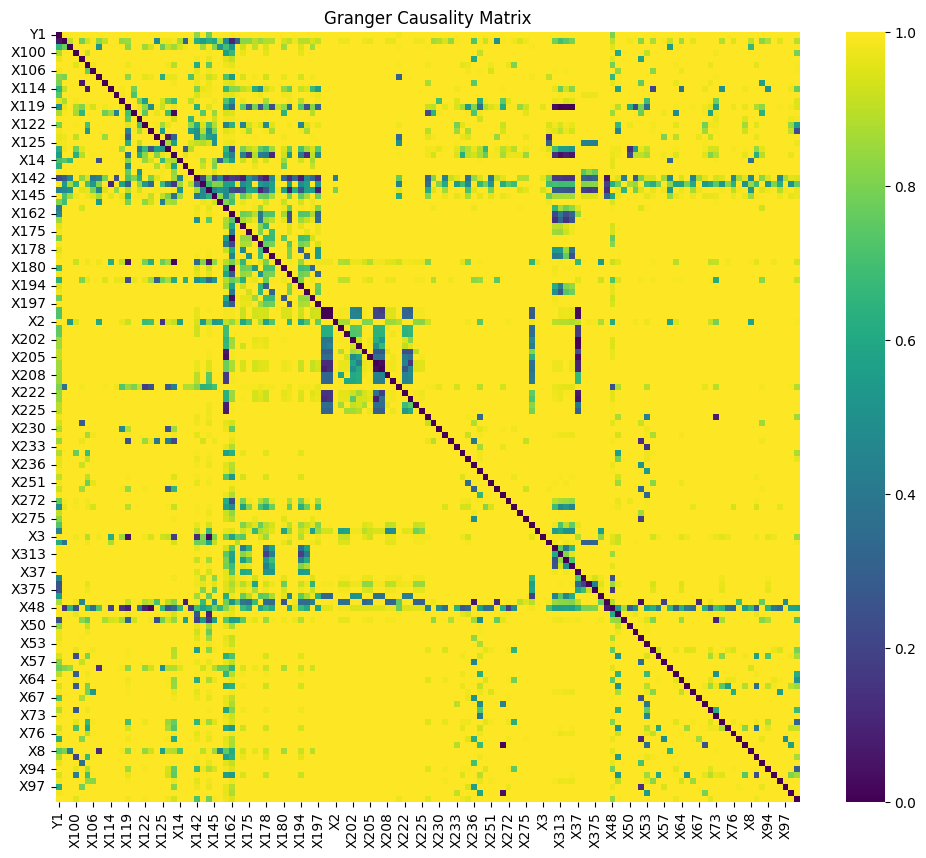

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Heatmap of Granger Causality Matrix
plt.figure(figsize=(12, 10))
sns.heatmap(gmat, cmap='viridis')
plt.title('Granger Causality Matrix')
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import grangercausalitytests
from sklearn_extra.cluster import KMedoids
from scipy.spatial.distance import pdist, squareform

def gfsm(F, gmat, target_index, output_name, threshold, clus, nbre_vars):
    # Filter out variables with low causality
    causality = gmat.iloc[:, target_index]
    relevant_vars = causality[causality >= threshold].index.tolist()

    # If only one variable is needed
    if nbre_vars == 1:
        max_caus_var = relevant_vars[0]
        for var in relevant_vars[1:]:
            if causality[var] > causality[max_caus_var]:
                max_caus_var = var
        GSM = F[[max_caus_var]]
        # No need to rename the column as it's already correctly named
        return GSM

    # Clustering
    if clus:
        # Compute distances
        distances = pdist(gmat.loc[relevant_vars, relevant_vars], metric='euclidean')
        dist_matrix = squareform(distances)

        # Find optimal number of clusters (k) based on silhouette score or use nbre_vars
        k = nbre_vars  # Placeholder for actual calculation
        display(k)
        # Perform KMedoids clustering
        kmedoids = KMedoids(n_clusters=k, random_state=0).fit(dist_matrix)
        print(kmedoids)
        display(kmedoids)
        labels = kmedoids.labels_

        # Select best variable from each cluster
        best_vars = []
        for cluster_idx in range(k):
            cluster_members = [relevant_vars[idx] for idx, label in enumerate(labels) if label == cluster_idx]
            # Select best variable based on maximum causality
            best_var = max(cluster_members, key=lambda var: causality[var])
            best_vars.append(best_var)

        GSM = F[best_vars]
    else:
        GSM = F[relevant_vars[:nbre_vars]]

    # Save the result
    # output_dir = f'Datasave/{output_name}_GFSM_Result.csv'
    # GSM.to_csv(output_dir, sep=";")
    return GSM

## Assuming target_index is known and gmat is computed
target_index = data.columns.get_loc(target_var)
gfsm_result = gfsm(data, gmat, target_index, 'output_name', threshold=0.99, clus=True, nbre_vars=5)
file_name = 'Datasave/Q_{num}_selected.pkl'.format(num=特定數字或標識符)
gfsm_result.to_pickle(file_name)

display(gfsm_result)


5

KMedoids(n_clusters=5, random_state=0)


KMedoids(n_clusters=5, random_state=0)

,X48,X18,X64,X313,X141
datetime,,,,,
2022-01-03 09:45:01,-0.007162,-2.029741,-1.438714,9.881427,-0.151333
2022-01-03 09:45:02,0.058105,-1.566579,-1.348658,8.213729,-0.444742
2022-01-03 09:45:03,0.009867,-1.336565,-1.034805,7.444207,-0.151126
2022-01-03 09:45:04,0.448261,-1.513061,-0.651514,7.453228,0.000000
2022-01-03 09:45:05,-0.053362,-1.591258,-0.604254,7.716840,0.000000
...,...,...,...,...,...
2022-01-03 12:14:56,-0.063597,0.187810,0.053049,4.836493,-0.196320
2022-01-03 12:14:57,-0.386080,0.044002,-0.001274,4.907804,-0.358989
2022-01-03 12:14:58,0.116594,-0.118372,-0.146023,5.016577,-0.339649


In [ ]:
target_index

0

In [ ]:
gfsm_result

,X48,X18,X64,X313,X141
datetime,,,,,
2022-01-03 09:45:01,-0.007162,-2.029741,-1.438714,9.881427,-0.151333
2022-01-03 09:45:02,0.058105,-1.566579,-1.348658,8.213729,-0.444742
2022-01-03 09:45:03,0.009867,-1.336565,-1.034805,7.444207,-0.151126
2022-01-03 09:45:04,0.448261,-1.513061,-0.651514,7.453228,0.000000
2022-01-03 09:45:05,-0.053362,-1.591258,-0.604254,7.716840,0.000000
...,...,...,...,...,...
2022-01-03 12:14:56,-0.063597,0.187810,0.053049,4.836493,-0.196320
2022-01-03 12:14:57,-0.386080,0.044002,-0.001274,4.907804,-0.358989
2022-01-03 12:14:58,0.116594,-0.118372,-0.146023,5.016577,-0.339649


In [ ]:
display(gmat)

,Y1,X1,X10,X100,X102,X104,X106,X11,X112,X114,...,X78,X8,X80,X92,X94,X95,X96,X97,X98,X99
Y1,0.000000,0.999997,1.000000,1.000000,0.999969,1.000000,1.000000,1.000000,0.999985,1.0,...,1.000000,1.000000,1.000000,0.999953,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
X1,0.047719,0.000000,0.903303,0.998352,0.783499,0.928212,0.991146,0.829838,0.908702,1.0,...,0.999987,0.905084,0.997194,0.823364,0.880510,1.000000,0.949695,0.999969,0.999765,0.894710
X10,0.658367,0.772763,0.000000,0.997925,0.999999,0.999981,1.000000,0.516810,1.000000,1.0,...,0.999832,0.671478,0.999891,1.000000,1.000000,1.000000,1.000000,0.999995,0.999972,0.998892
X100,0.873626,1.000000,1.000000,0.000000,1.000000,0.920199,1.000000,1.000000,1.000000,1.0,...,1.000000,1.000000,0.997563,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.789725
X102,0.967843,0.999795,1.000000,0.999937,0.000000,1.000000,1.000000,1.000000,1.000000,1.0,...,1.000000,1.000000,1.000000,0.998124,1.000000,1.000000,1.000000,1.000000,1.000000,0.999922
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
X95,0.942147,0.997026,1.000000,0.427246,1.000000,0.702507,1.000000,1.000000,1.000000,1.0,...,0.736001,1.000000,0.238910,1.000000,0.997082,0.000000,1.000000,1.000000,0.805916,0.859450
X96,0.981371,1.000000,1.000000,1.000000,1.000000,0.835221,0.821172,1.000000,1.000000,1.0,...,0.999969,1.000000,1.000000,1.000000,0.999721,1.000000,0.000000,1.000000,0.999924,0.996840
X97,0.622107,0.999992,1.000000,0.994422,0.791644,0.993570,0.999341,1.000000,1.000000,1.0,...,1.000000,1.000000,0.995500,0.966860,1.000000,0.999996,0.998650,0.000000,1.000000,0.999005
X98,0.984058,0.999987,1.000000,1.000000,1.000000,0.999972,1.000000,1.000000,1.000000,1.0,...,0.993247,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.999999
